In [3]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sklearn as sk

[*********************100%***********************]  1 of 1 completed

Coefficient: 0.004941782182047464
Intercept: -0.05269951077572416
R-Squared: 0.0005846716369696248


Price,Adj Close,Close,High,Low,Open,Volume,Close + 1,Target,RSI,Predictions,Residuals
13,1.460667,1.460667,1.483333,1.394667,1.424667,37297500,1.353333,-7.348288,43.408794,0.161817,7.510105
14,1.353333,1.353333,1.456667,1.336667,1.456667,27379500,1.348000,-0.394060,39.206237,0.141049,0.535109
15,1.348000,1.348000,1.393333,1.300000,1.377333,18787500,1.400000,3.857561,39.159154,0.140816,-3.716745
16,1.400000,1.400000,1.416667,1.358000,1.366667,14367000,1.419333,1.380929,46.915168,0.179145,-1.201784
17,1.419333,1.419333,1.437333,1.404000,1.412667,9804000,1.396667,-1.596946,57.983173,0.233841,1.830786
...,...,...,...,...,...,...,...,...,...,...,...
3758,295.140015,295.140015,305.500000,291.140015,298.829987,164747700,308.579987,4.553761,31.133902,0.101157,-4.452604
3759,308.579987,308.579987,309.829987,281.850006,285.959991,140908900,326.089996,5.674383,38.895882,0.139515,-5.534867
3760,326.089996,326.089996,327.829987,310.670013,314.940002,151256500,326.429993,0.104265,44.681104,0.168105,0.063840
3761,326.429993,326.429993,335.500000,322.500000,334.399994,122611400,319.109985,-2.242443,47.405107,0.181566,2.424009


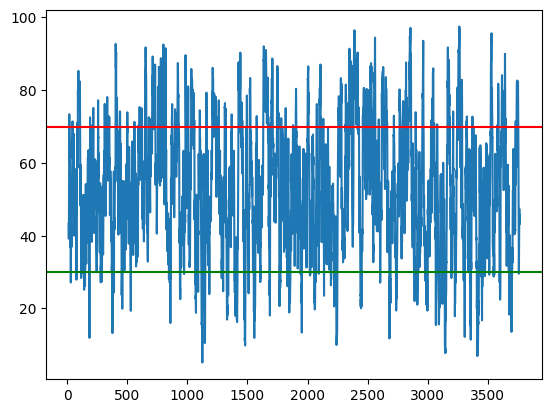

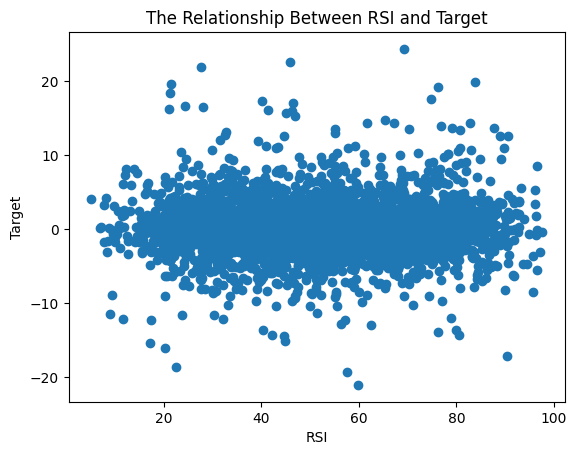

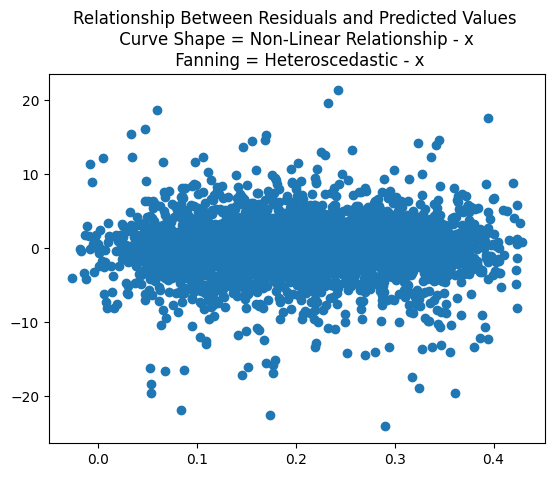

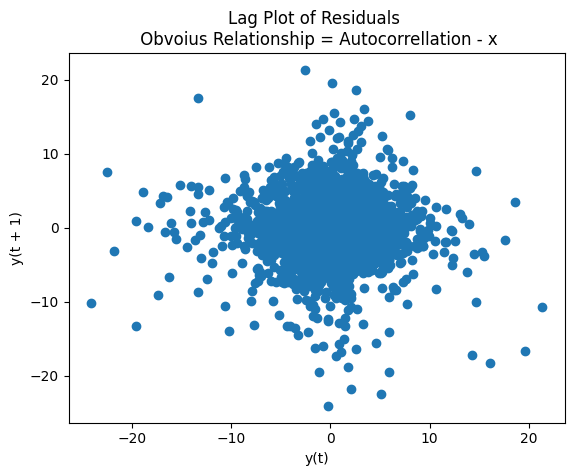

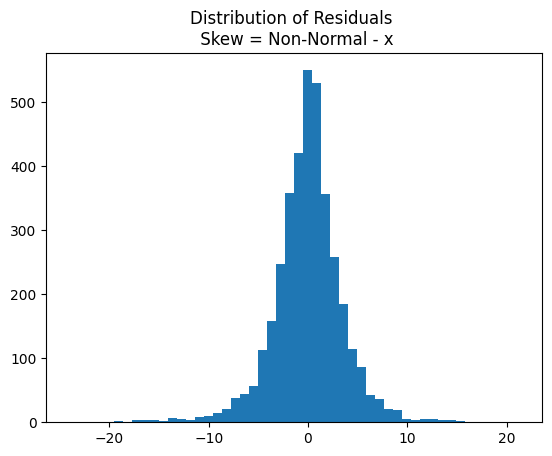

In [ ]:
TICKER = 'TSLA'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
STRATEGY = 'RSI'
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df['Target'] = (df[f'Close + {shift}'] - df['Close']) / df['Close'] * 100

    return df

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')

    return df.dropna()

def generate_regression_output(df, features='RSI', target='Target'):

    subset = df[[features, target]].dropna()

    # reshape for sklearn
    X = subset[[features]].values # 2d
    y = subset[target].values # 1d

    model = sk.linear_model.LinearRegression()
    model.fit(X, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(X)

    # what is the relationship between features and target?
    r2 = sk.metrics.r2_score(y, y_pred)

    # make coefficient variable
    coefficient = model.coef_[0]
    intercept = model.intercept_

    # coef, intercept, r2... mse later on
    print(f"Coefficient: {coefficient}")
    print(f"Intercept: {intercept}")
    print(f"R-Squared: {r2}")

    # plot a relationship between feature and target
    plt.figure()
    plt.title(f'The Relationship Between {features} and {target}')
    plt.scatter(X, y)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")

    return coefficient, intercept

def validate_regression_output(df, coef, intercept):

    # information necessary
    df['Predictions'] = coef * df[f'{STRATEGY}'] + intercept
    df['Residuals'] = df[f'{SHIFT} Period % Change'] - df['Predictions'] 

    # plot for linearity/homoscedasticity
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values \n ' \
        'Curve Shape = Non-Linear Relationship - x \n ' \
        'Fanning = Heteroscedastic - x')
    
    # plot for autocorrelations
    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals \n Obvoius Relationship = Autocorrellation - x')

    # plot for normality
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('Distribution of Residuals \n Skew = Non-Normal - x')

    return df


def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    fit_coef, fit_intercept = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coef, intercept=fit_intercept)

    return df

df = main()
df